# Assignment 1 - Deep Learning
The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.
This notebook uses the notMNIST dataset to be used with python experiments. This dataset is designed to look like the classic MNIST dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline


/Users/gautamsharma/anaconda/envs/tf-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


# Problem 1
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

In [4]:
def print_sample_images():
    """Print 1st sample of each character"""
    
    pixel_depth = 255.0
    
    # For each character (each folder)
    for folder in train_folders:
        # Get 1st image path in current folder
        image_file = os.path.join(folder, os.listdir(folder)[1])
        
        # Display 1st image of current folder
        display(Image(filename=image_file))
        
print_sample_images()

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.
We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.
A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

# Problem 2
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

============== A ==============


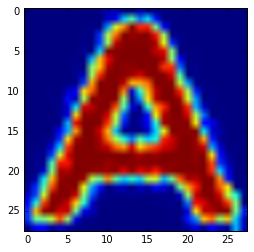

============== B ==============


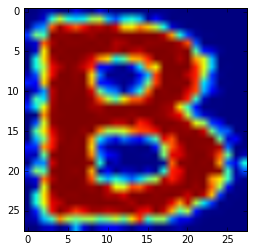

============== C ==============


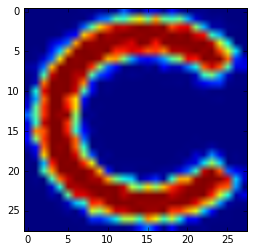

============== D ==============


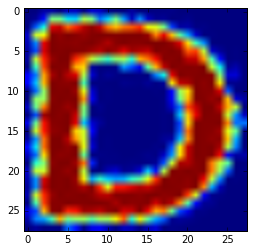

============== E ==============


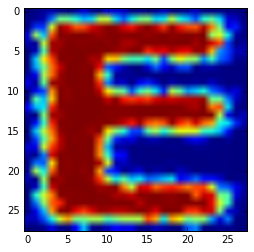

============== F ==============


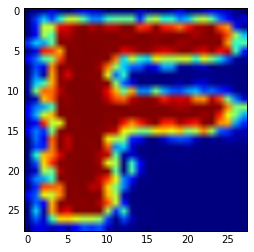

============== G ==============


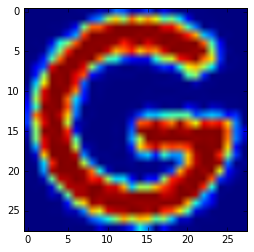

============== H ==============


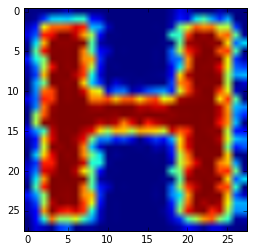

============== I ==============


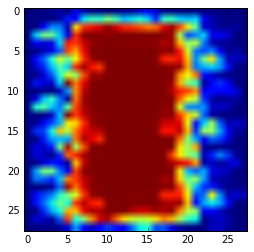

============== J ==============


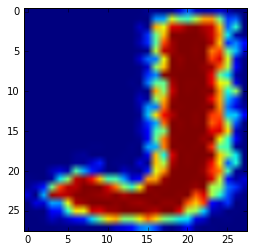

In [6]:
def visualize_and_get_sample_data():
    """Visualize 1st image of each character with corresponding label
       and return sample of data"""
    
    # Make <num_classes> matrices of shape <image_size> X <image_size> 
    sample_dataset = np.ndarray(shape=(num_classes, image_size, image_size),
                         dtype=np.float32)             
    # Labels list
    labels = [x[len(x)-1] for x in test_folders]
    
    # Load pickle objects of test set (I chose test set since it's pickle
    # is smaller in size which'll make it faster to get loaded)
    for i in range(len(test_datasets)):
        # Get 1st element of each pickle
        sample_dataset[i, :, :] = pickle.load(open(test_datasets[i], 'rb'))[0]
        
        # Display label
        print('==============', labels[i], '==============')
        
        # Display image
        plt.imshow(sample_dataset[i, :, :])
        plt.show()
        
    return sample_dataset, labels

sample_dataset, labels = visualize_and_get_sample_data()

# Problem 3
Another check: we expect the data to be balanced across classes. Verify that.


In [7]:
def check_balance_in_dataset(dataset):
    """Check balance across classes in dataset
       Return true if dataset is balanced and false otherwise"""
    
    # Imbalance is allowed up till + or - 5 images of all classes
    threshold_for_balance = 5
    
    # Set bench mark for number of images per class
    bench_mark_size = len(pickle.load(open(dataset[0], 'rb')))
    
    # For each class in dataset (skip 1st class since it is choosen as bench mark)
    for i in range(1, len(dataset)):
        # Get difference in number of images in current class and bench mark size
        diff_in_length = abs(pickle.load(open(dataset[i], 'rb')).shape[0] - bench_mark_size)
        
        # Print difference in length between current class and bench mark size
        print("Difference in length of data in {} with bench mark size:".format(dataset[i]), diff_in_length)
        
        #If imbalance is greater than threshold, return false
        if diff_in_length > threshold_for_balance:
            print("\n\nData is not balanced !")
            return False
    
    print("\n\nData is balanced !")
    return True

print("\n\nTesting balance between classes in training set...\n\n")
check_balance_in_dataset(train_datasets)
print("\n\nTesting balance between classes in test set...\n\n")
check_balance_in_dataset(test_datasets)



Testing balance between classes in training set...


Difference in length of data in notMNIST_large/B.pickle with bench mark size: 2
Difference in length of data in notMNIST_large/C.pickle with bench mark size: 3
Difference in length of data in notMNIST_large/D.pickle with bench mark size: 2
Difference in length of data in notMNIST_large/E.pickle with bench mark size: 3
Difference in length of data in notMNIST_large/F.pickle with bench mark size: 3
Difference in length of data in notMNIST_large/G.pickle with bench mark size: 3
Difference in length of data in notMNIST_large/H.pickle with bench mark size: 3
Difference in length of data in notMNIST_large/I.pickle with bench mark size: 3
Difference in length of data in notMNIST_large/J.pickle with bench mark size: 2


Data is balanced !


Testing balance between classes in test set...


Difference in length of data in notMNIST_small/B.pickle with bench mark size: 1
Difference in length of data in notMNIST_small/C.pickle with bench mark s

True

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.
Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes # operator '//' is floor division operator
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

# Problem 4
Convince yourself that the data is still good after shuffling!



Displaying sample of training data...

============== 4 ==============


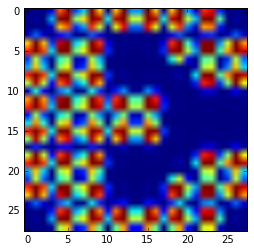

============== 9 ==============


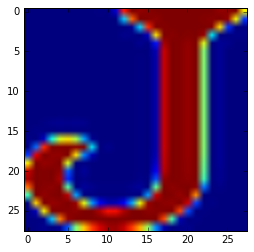

============== 6 ==============


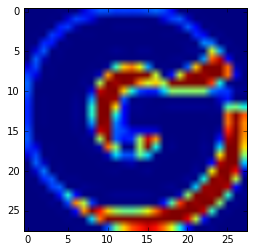

============== 2 ==============


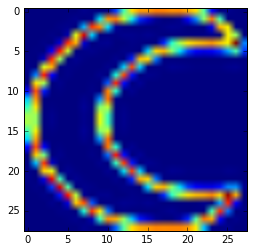



Displaying sample of validation data...

============== 1 ==============


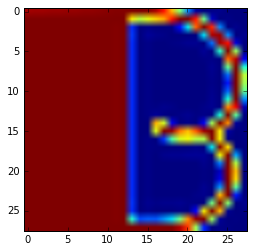

============== 9 ==============


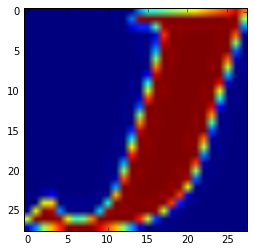

============== 3 ==============


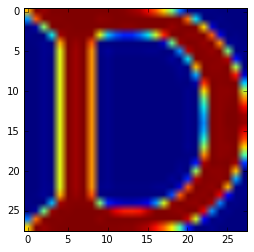

============== 8 ==============


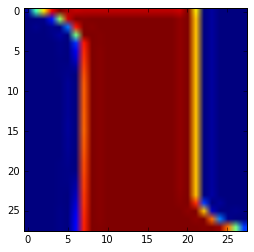



Displaying sample of test data...

============== 3 ==============


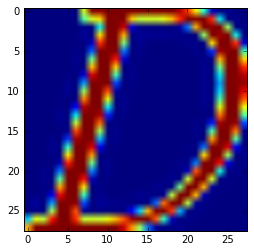

============== 6 ==============


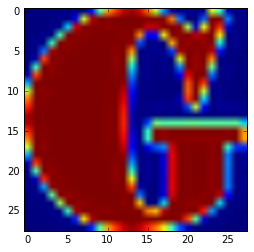

============== 4 ==============


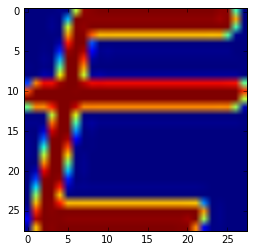

============== 7 ==============


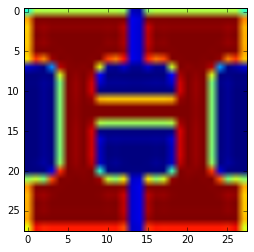

In [10]:
def print_randomized_sample(dataset, labels, sample_size=5):
    """Show sample of images of randomized dataset along with 
       labels to ensure data is still good after randomization
       Display 5 examples if sample size is not specified"""
   
    # Display each sample
    for i in range(sample_size):
        # Display label
        print('==============', labels[i], '==============')
        
        # Display image
        plt.imshow(dataset[i, :, :])
        plt.show()

# Print sample of training set - 4 examples
print("\n\nDisplaying sample of training data...\n")
print_randomized_sample(train_dataset, train_labels, 4)
# Print sample of validation set - 4 examples 
print("\n\nDisplaying sample of validation data...\n")
print_randomized_sample(valid_dataset, valid_labels, 4)
# Print sample of test set - 4 examples
print("\n\nDisplaying sample of test data...\n")
print_randomized_sample(test_dataset, test_labels, 4)


Finally, let's save the data for later reuse:

In [11]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise


Display size of pickled file in bytes

In [12]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


# Problem 5
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:

* What about near duplicates between datasets? (images that are almost identical)

* Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

# Solution Part 1: Find near duplicates using locality-sensitive hashing

In [13]:
from time import time
# ---------------------------------------------------
# Find Duplicates
# ---------------------------------------------------
# Inspired by eythian's method for duplicates
# https://discussions.udacity.com/t/assignment-1-problem-5/45657/10
# Tutorial on Locality-Sensitive Hashing https://www.youtube.com/watch?v=Arni-zkqMBA

t0 = time()
# Set data to read only so we can create hashes
train_dataset.flags.writeable=False
test_dataset.flags.writeable=False
valid_dataset.flags.writeable=False

# Get hashes for all images as a list (to preserve indices)
train_hashes = [hash(image.data) for image in train_dataset]
test_hashes = [hash(image.data) for image in test_dataset]
valid_hashes = [hash(image.data) for image in valid_dataset]

# Unique set of hashes found in train. And the set of hashes in test and 
# validation that overlap with the hashes the training data
unique_train_hashes = set(train_hashes)
test_overlap_hashes = unique_train_hashes.intersection(set(test_hashes))
valid_overlap_hashes = unique_train_hashes.intersection(set(valid_hashes))

# ---------------------------------------------------
# Create Dictionaries
# ---------------------------------------------------
# Dictionary Keys represent every unique hash from the training data.
# Dictionary Values are lists of indices in the corresponding dataset have that 
# hash.

# Initialise the dictionaries with empty lists
train_hash_dict =  {val: [] for val in unique_train_hashes}
test_hash_dict = {val: [] for val in test_overlap_hashes}
valid_hash_dict = {val: [] for val in valid_overlap_hashes}

# For the train set, append the indices to the corresponding hash
filter(lambda (i,val): train_hash_dict[val].append(i), enumerate(train_hashes))

# For test set, append indices only if the hash overlaps with train set
for i, image_hash in enumerate(test_hashes):
    if image_hash in test_overlap_hashes:
        test_hash_dict[image_hash].append(i)

# The same for the validation set (For validation set, append indices only if the hash overlaps with train set)
for i, image_hash in enumerate(valid_hashes):
    if image_hash in valid_overlap_hashes:
        valid_hash_dict[image_hash].append(i)
        
print("Duplicates inside training dataset: ", len(train_dataset) - len(train_hash_dict))
print('Duplicates between train and validation dataset: ', len(valid_hash_dict))
print('Duplicates between train and test dataset: ', len(test_hash_dict))
print("Found Duplicate indices in in", time() - t0, "seconds")

Duplicates inside training dataset:  12783
Duplicates between train and validation:  953
Duplicates between train and test:  1153
Found Duplicate indices in in 1.91067099571 seconds


# Solution Part 2: Create a sanitized validation and test set



Printing sample of sanitized training set...


============== 8 ==============


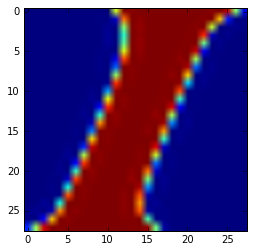

============== 1 ==============


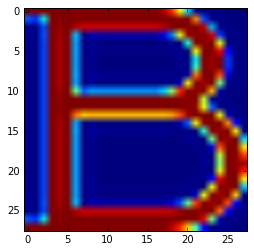

============== 3 ==============


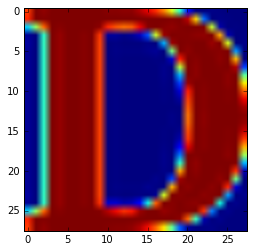

============== 5 ==============


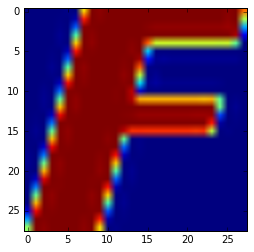

============== 1 ==============


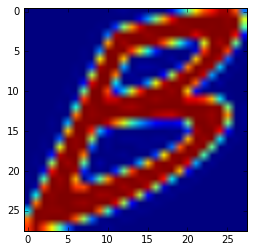

============== 1 ==============


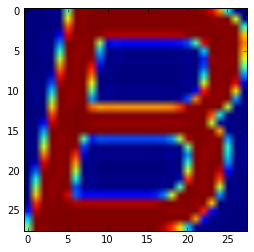

============== 8 ==============


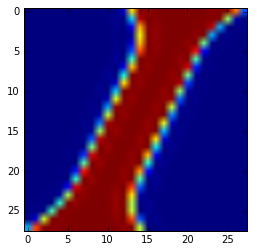

============== 7 ==============


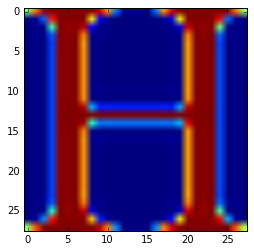

============== 1 ==============


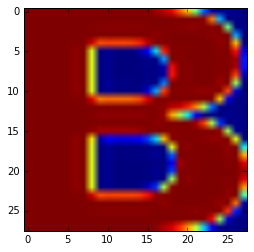

============== 5 ==============


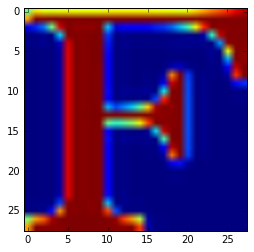



Printing sample of sanitized test set...


============== 8 ==============


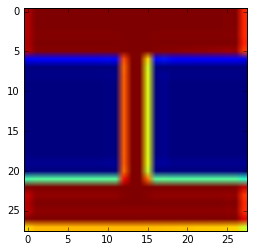

============== 9 ==============


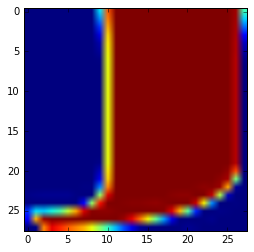

============== 8 ==============


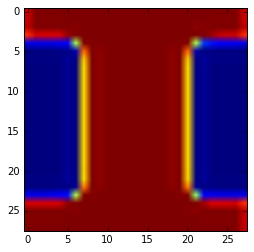

============== 8 ==============


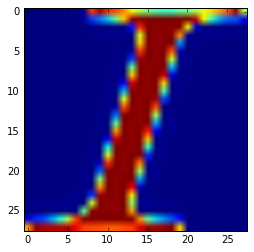

============== 2 ==============


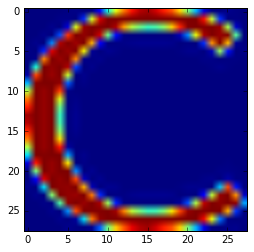

============== 4 ==============


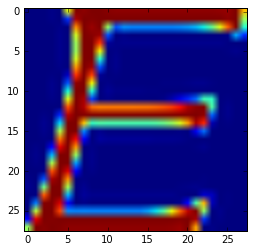

============== 9 ==============


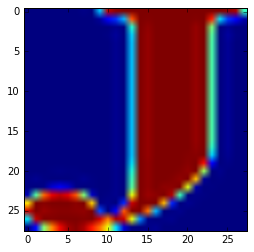

============== 9 ==============


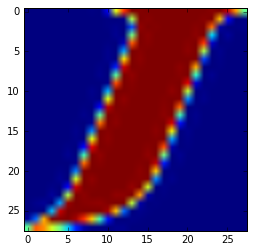

============== 6 ==============


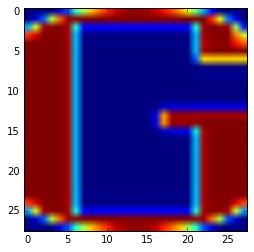

============== 2 ==============


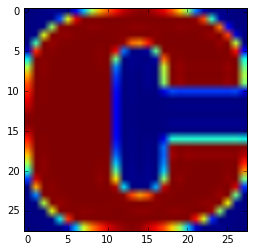



Printing sample of sanitized validation set...


============== 1 ==============


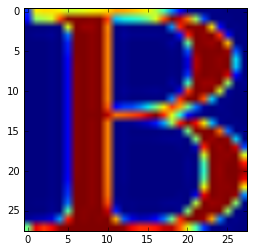

============== 0 ==============


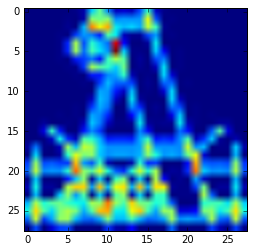

============== 7 ==============


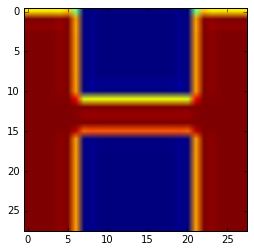

============== 0 ==============


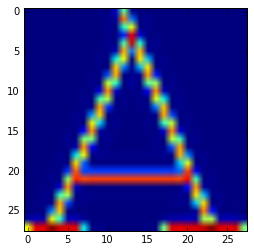

============== 5 ==============


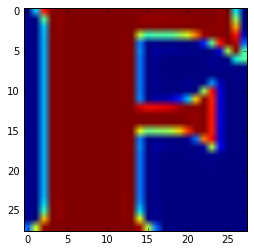

============== 4 ==============


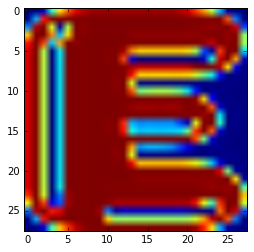

============== 6 ==============


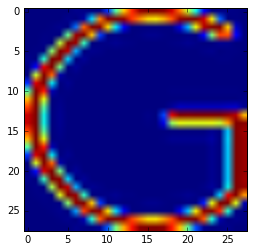

============== 7 ==============


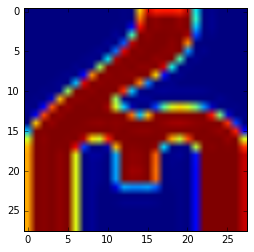

============== 5 ==============


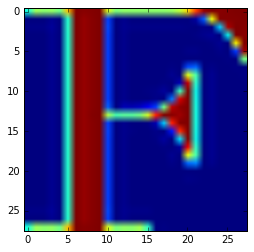

============== 9 ==============


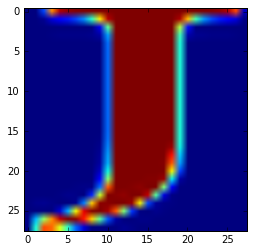

In [14]:
# ---------------------------------------------
# Discard near duplicates within training data
# ---------------------------------------------
sanitized_train_dataset = np.ndarray(shape=(len(train_hash_dict), image_size, image_size),
                         dtype=np.float32)
sanitized_train_labels = np.ndarray(len(train_hash_dict), dtype=np.int32)
for i, image_hash in enumerate(train_hash_dict):
    sanitized_train_dataset[i, :, :] = train_dataset[train_hash_dict[image_hash][0]]
    sanitized_train_labels[i] = train_labels[train_hash_dict[image_hash][0]]

# Display random subset of images to varify proper correspondence
# between sanitized training datasets and labels
print("\n\nPrinting sample of sanitized training set...\n\n")
for i in range(200, 210):
    print('==============', sanitized_train_labels[i], '==============')
    plt.imshow(sanitized_train_dataset[i, :, :])
    plt.show()

# ----------------------------------------------------------
# Discard near duplicates of training data within test set
# ----------------------------------------------------------

# Get list of indices near duplicates of training data within test set
ignore_test_indices = []
for image_hash in test_hash_dict:
    for index in test_hash_dict[image_hash]:
        ignore_test_indices.append(index)
        
sanitized_test_dataset = np.ndarray(shape=(len(test_dataset) - len(ignore_test_indices), image_size, image_size),
                         dtype=np.float32)
sanitized_test_labels = np.ndarray(len(test_dataset) - len(ignore_test_indices), dtype=np.int32)
ind = 0
for i in range(len(test_dataset)):
    if i not in ignore_test_indices:
        sanitized_test_dataset[ind, :, :] = test_dataset[i]
        sanitized_test_labels[ind] = test_labels[i]
        ind += 1
        
# Display random subset of images to varify proper correspondence
# between sanitized test datasets and labels
print("\n\nPrinting sample of sanitized test set...\n\n")
for i in range(200, 210):
    print('==============', sanitized_test_labels[i], '==============')
    plt.imshow(sanitized_test_dataset[i, :, :])
    plt.show()

# --------------------------------------------------------------
# Discard near duplicates of training data within validation set
# --------------------------------------------------------------

# Get list of indices near duplicates of training data within validation set
ignore_valid_indices = []
for image_hash in valid_hash_dict:
    for index in valid_hash_dict[image_hash]:
        ignore_valid_indices.append(index)
        
sanitized_valid_dataset = np.ndarray(shape=(len(valid_dataset) - len(ignore_valid_indices), image_size, image_size),
                         dtype=np.float32)
sanitized_valid_labels = np.ndarray(len(valid_dataset) - len(ignore_valid_indices), dtype=np.int32)
ind = 0
for i in range(len(valid_dataset)):
    if i not in ignore_valid_indices:
        sanitized_valid_dataset[ind, :, :] = valid_dataset[i]
        sanitized_valid_labels[ind] = valid_labels[i]
        ind += 1
        
# Display random subset of images to varify proper correspondence
# between sanitized valid datasets and labels
print("\n\nPrinting sample of sanitized validation set...\n\n")
for i in range(100, 110):
    print('==============', sanitized_valid_labels[i], '==============')
    plt.imshow(sanitized_valid_dataset[i, :, :])
    plt.show()

Pickle down the sanitized data

In [15]:
pickle_file = 'notMNIST_sanitized.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'sanitized_train_dataset': sanitized_train_dataset,
    'sanitized_train_labels': sanitized_train_labels,
    'sanitized_valid_dataset': sanitized_valid_dataset,
    'sanitized_valid_labels': sanitized_valid_labels,
    'sanitized_test_dataset': sanitized_test_dataset,
    'sanitized_test_labels': sanitized_test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

# Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.
Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

# Step 1 - Select Regularization Parameter
Select value for regularization parameter (lambda) using cross-validation set (as shown in Andrew's course).
In Andrew's course, we plot graph of lambda vs cost function (loss function in multinomial logistic regression), but I am using error (1-accuracy_score) in place of cost function (loss function) value.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s finished


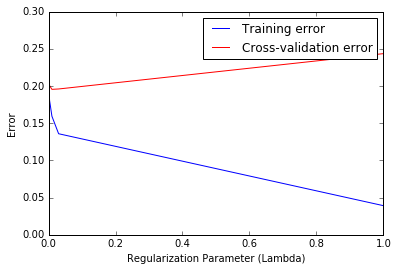

Minimum cost is 0.1955 with corresponding regularization parameter (lambda) value as 0.01


In [53]:
# Regularization parameter values to be used
lambda_values = np.array([0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 1.0])

# Error array (1 - accuracy) with index correspond to each regularization parameter value
train_error_values = np.array([0.0]*len(lambda_values))
valid_error_values = np.array([0.0]*len(lambda_values))

# Set training, validation and test set sizes (60-20-20 split of dataset)
train_size = 6000
valid_size = train_size / 3
test_size = train_size / 3 

# Replace original dataset by sanitized dataset
train_dataset = sanitized_train_dataset[0:train_size, :, :]
valid_dataset = sanitized_valid_dataset[0:valid_size, :, :]
test_dataset = sanitized_test_dataset[0:test_size, :, :]
train_labels = sanitized_train_labels[0:train_size]
valid_labels = sanitized_valid_labels[0:valid_size]
test_labels = sanitized_test_labels[0:test_size]

# Flatten dataset for training the model
flatten_train_dataset = train_dataset.reshape((train_size, image_size*image_size))
flatten_valid_dataset = valid_dataset.reshape((valid_size, image_size*image_size))

from sklearn.metrics import accuracy_score

# Create & train Multinomial Logistic Regression model with different regularization parameter values
# and calculate errors of each of them on training and validation set
for i, L in enumerate(lambda_values):
    # Create and train model
    clf = LogisticRegression(C=L, multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000)
    clf.fit(flatten_train_dataset, train_labels)
    # Predict
    pred_train_labels = clf.predict(flatten_train_dataset)
    pred_valid_labels = clf.predict(flatten_valid_dataset)
    # Calculate error
    accuracy_train = accuracy_score(train_labels, pred_train_labels)
    accuracy_valid = accuracy_score(valid_labels, pred_valid_labels)
    train_error_values[i] = 1 - accuracy_train
    valid_error_values[i] = 1 - accuracy_valid
    
# Plot curves 
plt.plot(lambda_values, train_error_values, 'b', label='Training error')
plt.plot(lambda_values, valid_error_values, 'r', label='Cross-validation error')
plt.xlabel('Regularization Parameter (Lambda)')
plt.ylabel('Error')
plt.legend()
plt.show()

# Set regularization_parameter value
reg_param = lambda_values[valid_error_values.argmin()]

print('Minimum cost is {} with corresponding regularization parameter (lambda) value as {}'.format(
                                                                                    min(valid_error_values),
                                                                                    reg_param))

# Step 2 - Train models for different training set sizes
Train models with different sizes of dataset (m) and plot Learning Curves to check bias-variance tradeoff in the model.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Training set size = 50
Score for training set: 0.92
Score for validation set: 0.5625
Score for test set: 0.3125 


Training set size = 100
Score for training set: 0.9
Score for validation set: 0.757575757576
Score for test set: 0.666666666667 




[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Training set size = 1000
Score for training set: 0.854
Score for validation set: 0.795795795796
Score for test set: 0.876876876877 




[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


Training set size = 5000
Score for training set: 0.8436
Score for validation set: 0.801920768307
Score for test set: 0.884753901561 




[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


Training set size = 10000
Score for training set: 0.8405
Score for validation set: 0.807380738074
Score for test set: 0.883888388839 




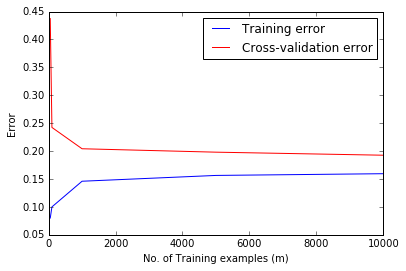

In [58]:
# Training set sizes ranges from 1K to 10K (i.e different values for m)
train_sizes = [50, 100, 1000, 5000, 10000]

# Error array (1 - accuracy) with index correspond to each training set size
train_error_values = np.array([0.0]*len(train_sizes))
valid_error_values = np.array([0.0]*len(train_sizes))
test_error_values = np.array([0.0]*len(train_sizes))

from sklearn.metrics import accuracy_score

for i, train_size in enumerate(train_sizes):
    # Set validation and test sizes (60-20-20 split of dataset) according to training set size
    valid_size = train_size / 3
    test_size = train_size / 3
    
    # Form dataset with desired size
    train_dataset = sanitized_train_dataset[0:train_size, :, :]
    valid_dataset = sanitized_valid_dataset[0:valid_size, :, :]
    test_dataset = sanitized_test_dataset[0:test_size, :, :]
    train_labels = sanitized_train_labels[0:train_size]
    valid_labels = sanitized_valid_labels[0:valid_size]
    test_labels = sanitized_test_labels[0:test_size]

    # Flatten dataset for training the model
    flatten_train_dataset = train_dataset.reshape((train_size, image_size*image_size))
    flatten_valid_dataset = valid_dataset.reshape((valid_size, image_size*image_size))
    flatten_test_dataset = test_dataset.reshape((test_size, image_size*image_size))

    # Create and train model
    clf = LogisticRegression(C=reg_param, multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000)
    clf.fit(flatten_train_dataset, train_labels)
    # Predict
    pred_train_labels = clf.predict(flatten_train_dataset)
    pred_valid_labels = clf.predict(flatten_valid_dataset)
    pred_test_labels = clf.predict(flatten_test_dataset)
    # Calculate error
    accuracy_train = accuracy_score(train_labels, pred_train_labels)
    accuracy_valid = accuracy_score(valid_labels, pred_valid_labels)
    accuracy_test = accuracy_score(test_labels, pred_test_labels)
    train_error_values[i] = 1 - accuracy_train
    valid_error_values[i] = 1 - accuracy_valid
    test_error_values[i] = 1 - accuracy_test
    
    # Print stats
    print('Training set size =', train_size)
    print('Score for training set:', accuracy_train)
    print('Score for validation set:', accuracy_valid)
    print('Score for test set:', accuracy_test, '\n\n')

# Plot curves 
plt.plot(train_sizes, train_error_values, 'b', label='Training error')
plt.plot(train_sizes, valid_error_values, 'r', label='Cross-validation error')
plt.xlabel('No. of Training examples (m)')
plt.ylabel('Error')
plt.legend()
plt.show()


Observing the above graph of training set size vs error, it is evident that our model is not suffering from either high bias (underfit) or high variance (overfit)